<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/julia_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
plt.style.use('default')
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [0]:
@cuda.jit(device=True)
def julia(x, y, max_iters, cin):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    #c = complex(-0.8, 0.156)
    #c = complex(0.274, -0.008)
    #c = complex(0.28, 0.008)
    #c = complex(0.3, -0.01)
    c = complex(cin[0], cin[1])
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return int((i/max_iters)*255)
    return 255

In [0]:
@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters, c):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    x, y = cuda.grid(2)
    
    if x < width and y < height:
      real = min_x + x * pixel_size_x
      imag = min_y + y * pixel_size_y
      color = julia(real, imag, iters, c)
      image[y, x] = color

In [0]:
image = np.zeros((1800, 1800), dtype=np.uint8)
threadsperblock = 16
threads_per_block = (16, 16)
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock
blocks_per_grid = (xblocks, yblocks)

In [0]:
reals = np.linspace(0.3,0.28,100)
imags = np.linspace(-0.01,0.008,100)
reals = np.linspace(0.28,-0.12,200)
imags = np.linspace(0.008,-0.77,200)
c = np.column_stack((reals, imags))

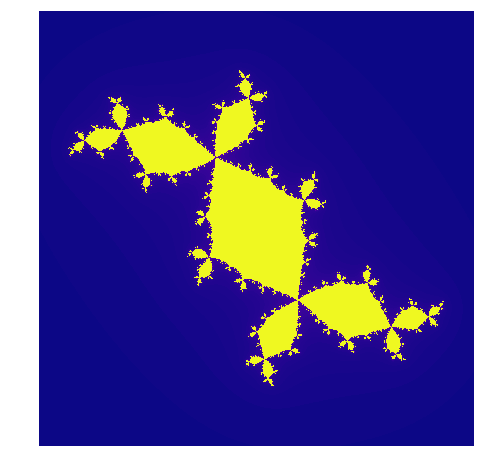

In [101]:
i = 199
create_fractal[blocks_per_grid, threads_per_block](-1.5, 1.5, -1.5, 1.5, image, 200, c[i])
plt.figure(figsize=(8,8))
plt.imshow(image, cmap="plasma")
plt.axis('off')
plt.show()

In [94]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [102]:
imageList = []
image = np.zeros((1800, 1800), dtype=np.uint8)
for i in range(200):
  print(i)
  create_fractal[blocks_per_grid, threads_per_block](-1.5, 1.5, -1.5, 1.5, image, 200, c[i])
  fig = plt.figure(figsize=(8,8))
  plt.xlim(( 0, 1800))
  plt.ylim((0, 1800))
  plt.axis('off')
  im = plt.imshow(image, cmap='plasma', animated=True, vmin=0, vmax=255)
  plt.savefig('/content/gdrive/My Drive/pngs/'+str(i)+'.png')
  plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
